In [135]:
import numpy as np

img_embed = np.load("fear_resnet50_image_embeddings.npz", allow_pickle=True)

img_embed.files
len(img_embed['arr_3000'][2][0])

2048

In [136]:
word_embed = np.load("bert_word_embeddings_fear.npz", allow_pickle=True)

word_embed.files
len(word_embed['arr_3000'][2][0])

768

In [137]:
data = []
labels= []

from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline, FeatureUnion

for i in range(0, 3012):
            
    key_str = 'arr_' + str(i)
    data.append(np.concatenate((word_embed[key_str][2][0], img_embed[key_str][2][0]), axis=None))
    labels.append(word_embed[key_str][1][0])

In [138]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
data = scaler.fit_transform(data)

data.shape
data[0]

array([-0.02023162, -0.1849499 , -0.8178115 , ..., -0.42791877,
        2.32099572, -0.88582175])

In [139]:
neg, pos = np.bincount(labels)

total = neg + pos

print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Examples:
    Total: 3012
    Positive: 317 (10.52% of total)

Weight for class 0: 0.56
Weight for class 1: 4.75


In [140]:
pos_features = []
neg_features = []
pos_labels = []
neg_labels = []

for i, sample in enumerate(data):
    if labels[i] == 1:
        pos_features.append(sample)
        pos_labels.append(1)
    else:
        neg_features.append(sample)
        neg_labels.append(0)
        
pos_features = np.array(pos_features)
pos_labels = np.array(pos_labels)

ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(2695, 2816)

In [141]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(5390, 2816)

In [142]:
data = resampled_features
labels = resampled_labels

In [143]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
# matplotlib.use("Agg")

# import the necessary packages
import time
import pandas as pd
import seaborn as sn
import keras
import os
import cv2
import pickle
import random
import argparse
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense
from keras.preprocessing.image import img_to_array
from keras.models import Model
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from keras.losses import logcosh, binary_crossentropy
from keras.activations import relu, elu, sigmoid
from keras.preprocessing.image import ImageDataGenerator
# import matplotlib
# matplotlib.use("Agg")

In [144]:
# initialize the number of epochs to train for, initial learning rate,
# batch size, and image dimensions
EPOCHS = 40
INIT_LR = 1e-3
BS = 128
IMAGE_DIMS = (224, 224, 3)

In [145]:
from sklearn.model_selection import train_test_split

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
    labels, test_size=0.2, random_state=42)
testX

array([[ 0.18240088, -1.13800003,  0.46699412, ..., -0.22034671,
        -0.64321986,  3.50277565],
       [-0.20200269, -0.50100671,  0.30020976, ...,  0.091238  ,
         0.76937792,  0.13480744],
       [ 0.16245863, -1.88375306,  0.27790731, ...,  0.87514554,
        -0.78774755, -0.49105633],
       ...,
       [-0.36908774,  0.37719319,  0.36823693, ..., -0.31731948,
        -0.78774755, -0.36412564],
       [-0.36717361,  0.68329561, -0.63669642, ..., -0.46022401,
        -0.78774755, -0.27951916],
       [ 1.36788758, -0.30251711, -0.88122291, ..., -0.64263114,
         1.24695616, -0.65908807]])

In [146]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(trainY)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_trainY = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded_trainY)

# integer encode
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(testY)
print(integer_encoded)

onehot_encoder = OneHotEncoder(sparse=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded_testY = onehot_encoder.fit_transform(integer_encoded)
print(onehot_encoded_testY)

[0 0 0 ... 0 1 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]
[0 1 0 ... 1 0 1]
[[1. 0.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [147]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2

model = Sequential([
    Dense(1024, input_shape=(2816,), activation='relu'),#, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
#     Dropout(0.2),
    Dense(1024, activation='relu'),#, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
#     Dropout(0.2),
    Dense(512, activation='relu'),#, kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
#     Dropout(0.2),
    Dense(2,activation='softmax')
])
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
    metrics=["accuracy"])
print("[INFO] done compiling.")

model.summary()


[INFO] done compiling.
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 1024)              2884608   
_________________________________________________________________
dense_34 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
dense_35 (Dense)             (None, 512)               524800    
_________________________________________________________________
dense_36 (Dense)             (None, 2)                 1026      
Total params: 4,460,034
Trainable params: 4,460,034
Non-trainable params: 0
_________________________________________________________________


In [148]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
    horizontal_flip=True, fill_mode="nearest")

In [149]:
trainY

array([0, 0, 0, ..., 0, 1, 0])

In [150]:
# train the network
print("[INFO] training network...")

H = model.fit(trainX, onehot_encoded_trainY, epochs=EPOCHS, batch_size=BS, validation_split=0.2) #class_weight=class_weight)

# save the model to disk
print("[INFO] serializing network...")
model.save("fear_oversampled_fusion_embeddings_fully_connected.model")

[INFO] training network...
Train on 3449 samples, validate on 863 samples
Epoch 1/40
3449/3449 [==============================] - 0s 84us/step - loss: 0.5981 - accuracy: 0.8115 - val_loss: 0.2584 - val_accuracy: 0.9119
Epoch 2/40
3449/3449 [==============================] - 0s 49us/step - loss: 0.1880 - accuracy: 0.9382 - val_loss: 0.1552 - val_accuracy: 0.9583
Epoch 3/40
3449/3449 [==============================] - 0s 49us/step - loss: 0.1499 - accuracy: 0.9510 - val_loss: 0.1410 - val_accuracy: 0.9594
Epoch 4/40
3449/3449 [==============================] - 0s 49us/step - loss: 0.1372 - accuracy: 0.9522 - val_loss: 0.1495 - val_accuracy: 0.9606
Epoch 5/40
3449/3449 [==============================] - 0s 49us/step - loss: 0.1355 - accuracy: 0.9542 - val_loss: 0.1561 - val_accuracy: 0.9583
Epoch 6/40
3449/3449 [==============================] - 0s 48us/step - loss: 0.1315 - accuracy: 0.9568 - val_loss: 0.1516 - val_accuracy: 0.9606
Epoch 7/40
3449/3449 [==============================] - 

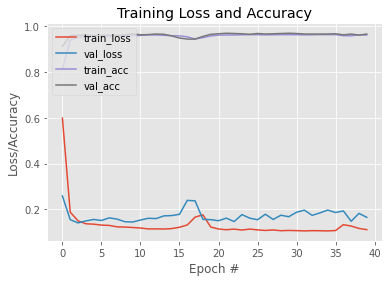

<Figure size 432x288 with 0 Axes>

In [151]:
plt.style.use("ggplot")
%matplotlib inline
plt.figure()
N = EPOCHS
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('fear_oversampled_fusion_embeddings_fully_connected_plot.png', dpi=100)

In [152]:
yhat_probs = model.predict(testX)
yhat_classes = np.argmax(yhat_probs, axis=1)

yhat_classes

array([1, 1, 0, ..., 1, 0, 1], dtype=int64)

Classification report: 
---------------------------------------------------------- 
              precision    recall  f1-score   support

        fear       1.00      0.91      0.95       545
    non-fear       0.92      1.00      0.96       533

    accuracy                           0.95      1078
   macro avg       0.96      0.96      0.95      1078
weighted avg       0.96      0.95      0.95      1078

---------------------------------------------------------- 
Accuracy score: 0.954545
Precision score: 0.917241
Recall score: 0.998124
F1 score: 0.955975
---------------------------------------------------------- 
Confusion matrix: 
[[497  48]
 [  1 532]]


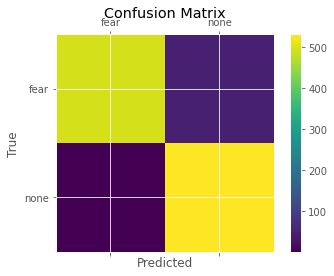

[[497  48]
 [  1 532]]


In [153]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from keras.models import Sequential
from keras.layers import Dense
 
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn

classif_report = classification_report(testY, yhat_classes, target_names=['fear', 'non-fear'])
print('Classification report: ')
print('---------------------------------------------------------- ')
print(classif_report)

print('---------------------------------------------------------- ')
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testY, yhat_classes)
print('Accuracy score: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testY, yhat_classes)
print('Precision score: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testY, yhat_classes)
print('Recall score: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testY, yhat_classes)
print('F1 score: %f' % f1)
print('---------------------------------------------------------- ')

# confusion matrix
labels = ['fear', 'none']
matrix = confusion_matrix(testY, yhat_classes)
print('Confusion matrix: ')
print(matrix)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix)
plt.title('Confusion Matrix')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('confusion_matrix_fear_oversampled_fusion_embeddings_fully_connected.png')
plt.show()
print(matrix)